In [1]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from astropy.table import QTable

plt.style.use('paper.mplstyle')

import warnings
warnings.filterwarnings('ignore')

import sys 
sys.path.append('../../../../misc/data_cube_analysis')  
from bindata import *
from histograms import *

sys.path.append('../run_catalogue/')
from imports import *  

In [2]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table

<QTable length=7710>
gal_name region_ID  x_max  ... HA6562_LUMINOSITY_ERR_HST region_circ_rad_pc_MUSE
                     pix   ...          erg / s                     pc          
bytes32   float64  float64 ...          float64                  float64        
-------- --------- ------- ... ------------------------- -----------------------
  IC5332       3.0    43.0 ...    1.5166846653343637e+35      39.738456871229964
  IC5332       7.0    50.0 ...    1.9274097864630476e+35      47.787933096066894
  IC5332      10.0    42.0 ...    1.0063673556433794e+35       40.64515429656436
  IC5332      11.0    29.0 ...    1.5390562448583934e+35      27.443226315629175
  IC5332      15.0    34.0 ...    1.3091603754614203e+35      34.148760044234734
  IC5332      17.0    67.0 ...    2.5056145612124907e+35      59.147387412092584
  IC5332      19.0    36.0 ...    1.3914665143723278e+35      33.429758255713466
  IC5332      26.0    82.0 ...    3.4211062126575066e+35       70.74372607445731
  IC5332      28.0    51.0 ...    2.7861368587550594e+35       46.23763967834349
     ...       ...     ... ...                       ...                     ...
 NGC7496     707.0    30.0 ...     6.781789007928015e+35       65.57333544888053
 NGC7496     721.0    54.0 ...    1.6431386228489705e+36       79.98347415215345
 NGC7496     725.0    32.0 ...    1.2916739954797644e+36       58.82911520385716
 NGC7496     726.0    33.0 ...     8.091280102694249e+35       62.29256423346252
 NGC7496     733.0    29.0 ...    4.4295641037495444e+35      60.585593809290806
 NGC7496     735.0    27.0 ...     1.100328446742663e+36       63.12874344985725
 NGC7496     743.0    32.0 ...     6.951715212585181e+35       62.29256423346252
 NGC7496     744.0    28.0 ...    4.4895380037313814e+35       63.95399080851588
 NGC7496     765.0    25.0 ...     1.323659843597203e+36       62.29256423346252
 NGC7496     776.0    31.0 ...    1.8141170984024623e+35       61.44500685981095

In [3]:
# Load sample table 
sample_table_file = '%s/data_misc/sample_table/phangs_sample_table_v1p6.fits' %root_dir
sample_table = QTable.read(sample_table_file)

# Load the MUSE table
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir
table_muse = QTable.read(muscat_table_file)

# Make column names consistent
columns = table_muse.colnames
for column in columns:
    table_muse.rename_column(column, column+'_MUSE')
table_muse.rename_column('gal_name_MUSE', 'gal_name')
table_muse.rename_column('region_ID_MUSE', 'region_ID')
table_muse.rename_column('Lum_HA6562_CORR_MUSE', 'HA6562_LUMINOSITY_MUSE')

# Get radius in pc
for gal_name in np.unique(table_muse['gal_name']):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    table_muse['region_circ_rad_pc_MUSE'] = cat_props.calculate_radius(table_muse['region_circ_rad_MUSE'], dist)  

table_muse

<QTable length=31497>
gal_name region_ID ... HII_class_v3_MUSE region_circ_rad_pc_MUSE
                   ...                              pc          
bytes32   float64  ...       int64               float64        
-------- --------- ... ----------------- -----------------------
  IC5332       0.0 ...                 0      111.24393696640297
  IC5332       1.0 ...                 0       57.93090802750168
  IC5332       2.0 ...                 0       56.09136050529689
  IC5332       3.0 ...                 0       82.56424710829474
  IC5332       4.0 ...                 1       56.09136050529689
  IC5332       5.0 ...                 0       56.09136050529689
  IC5332       6.0 ...                 1      54.189402485905866
  IC5332       7.0 ...                 1       99.28857403103791
  IC5332       8.0 ...                 0       57.93090802750168
     ...       ... ...               ...                     ...
 NGC7496     767.0 ...                 1      59.713813196332865
 NGC7496     768.0 ...                 1      59.713813196332865
 NGC7496     769.0 ...                 1       58.82911520385716
 NGC7496     770.0 ...                 0       57.01855324465027
 NGC7496     771.0 ...                 0       57.93090802750168
 NGC7496     772.0 ...                 1      59.713813196332865
 NGC7496     773.0 ...                 1      59.713813196332865
 NGC7496     774.0 ...                 1       61.44500685981095
 NGC7496     775.0 ...                 1       57.01855324465027
 NGC7496     776.0 ...                 1       61.44500685981095

In [4]:
mask_flags = ~((table['flag_edge_hst']==1)|(table['flag_edge_MUSE']==1)|(table['flag_star_MUSE']==1))
table = table[mask_flags]

mask_flags = ~((table_muse['flag_edge_MUSE']==1)|(table_muse['flag_star_MUSE']==1))
table_muse = table_muse[mask_flags] 

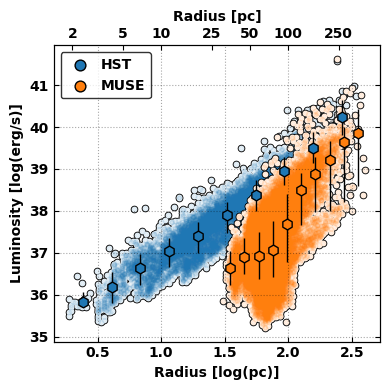

In [5]:
data_x1 = np.log10(table['radius_circ_pc'].value)
data_y1 = np.log10(table['HA6562_LUMINOSITY_HST'].value)

# data_x2 = np.log10(table['region_circ_rad_pc_MUSE'].value)
# data_y2 = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

data_x2 = np.log10(table_muse['region_circ_rad_pc_MUSE'].value)
data_y2 = np.log10(table_muse['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

for i, (data_x, data_y) in enumerate(zip([data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.scatter([], [], s=60, ec='black', fc='C0', zorder=10, label='HST')
ax.scatter([], [], s=60, ec='black', fc='C1', zorder=10, label='MUSE')
ax.legend(loc='upper left', edgecolor='black', handletextpad=0.5)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_wmuse.pdf', dpi=200, bbox_inches='tight')

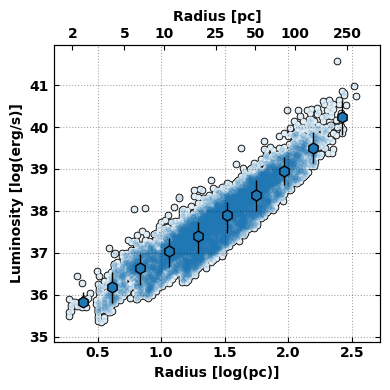

In [6]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all.pdf', dpi=200, bbox_inches='tight')

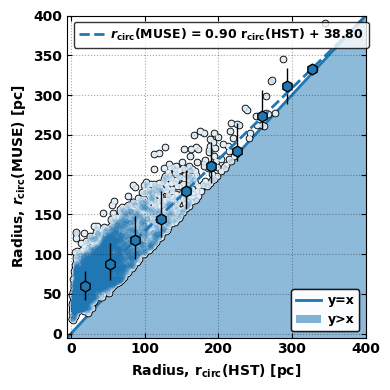

In [71]:
data_x = table['radius_circ_pc'].value
data_y = table['region_circ_rad_pc_MUSE'].value

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

from scipy.optimize import curve_fit
def fit_func(x, a, b):
    return a*x + b
params = curve_fit(fit_func, x, y)
xs = np.linspace(0, 500, 100)
ys = fit_func(xs, *params[0])

line1,  = ax.plot(xs, ys, color='C0', lw=2, ls='--', label='$r_\mathrm{circ}$(MUSE) = %.2f r$_\mathrm{circ}$(HST) + %.2f' %tuple(params[0]))

line2, = ax.plot([-100,500], [-100,500], color='C0', lw=2, ls='-', label='y=x', zorder=0)
line3 = ax.fill_between([-100,500], [-100,500], fc='C0', ec='none', alpha=0.5, label='y<x', y2=-10, zorder=0)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, r$_\mathrm{circ}$(HST) [pc]')
ax.set_ylabel('Radius, $r_\mathrm{circ}$(MUSE) [pc]')

ax.set_xlim(-5, 400)
ax.set_ylim(-5, 400)

# legend1 = ax.legend(loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)
# legend2 = ax.legend(loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)

lines = ax.get_lines()
legend1 = plt.legend([line1], ['$r_\mathrm{circ}$(MUSE) = %.2f r$_\mathrm{circ}$(HST) + %.2f' %tuple(params[0])], loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)
legend2 = plt.legend([line2, line3], ['y=x','y>x'], loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)
ax.add_artist(legend1)
ax.add_artist(legend2)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radrad_all.pdf', dpi=200, bbox_inches='tight')

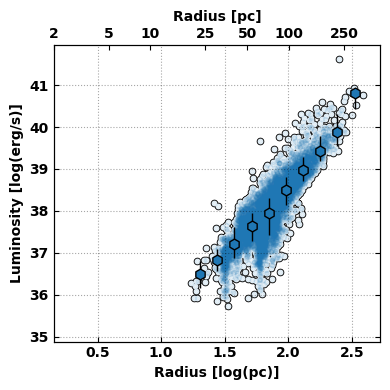

In [7]:
data_x = np.log10(table['region_circ_rad_pc_MUSE'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_muse.pdf', dpi=200, bbox_inches='tight')

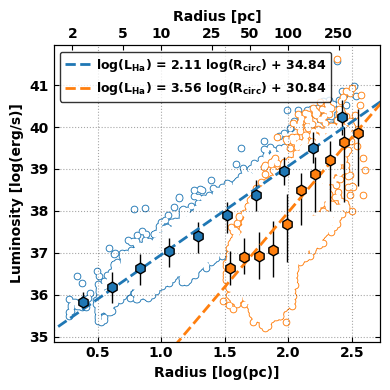

In [8]:
data_x1 = np.log10(table['radius_circ_pc'].value)
data_y1 = np.log10(table['HA6562_LUMINOSITY_HST'].value)

# data_x2 = np.log10(table['region_circ_rad_pc_MUSE'].value)
# data_y2 = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

data_x2 = np.log10(table_muse['region_circ_rad_pc_MUSE'].value)
data_y2 = np.log10(table_muse['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

for i, (data_x, data_y) in enumerate(zip([data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=20, c='C%i' %i, rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    # ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i)

    from scipy.optimize import curve_fit
    def fit_func(x, a, b):
        return a*x + b
    params = curve_fit(fit_func, x, y)
    xs = np.linspace(0, 3, 100)
    ys = fit_func(xs, *params[0])
    ax.plot(xs, ys, color='C%i'%i, lw=2, ls='--', label='log(L$_\mathrm{Ha}$) = %.2f log(R$_\mathrm{circ}$) + %.2f' %tuple(params[0]))

    # ax.plot([], [], c='C0', ls='--', label='HST: L$_\mathrm{Ha}$ = %.2f R$_\mathrm{circ}$  + %.2f' %tuple(params[0]))
    # ax.plot([], [], c='C1', ls='--', label='MUSE: L$_\mathrm{Ha}$ = %.2f R$_\mathrm{circ}$  + %.2f' %tuple(params[0]))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.legend(loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_wmuse_wfit.pdf', dpi=200, bbox_inches='tight')

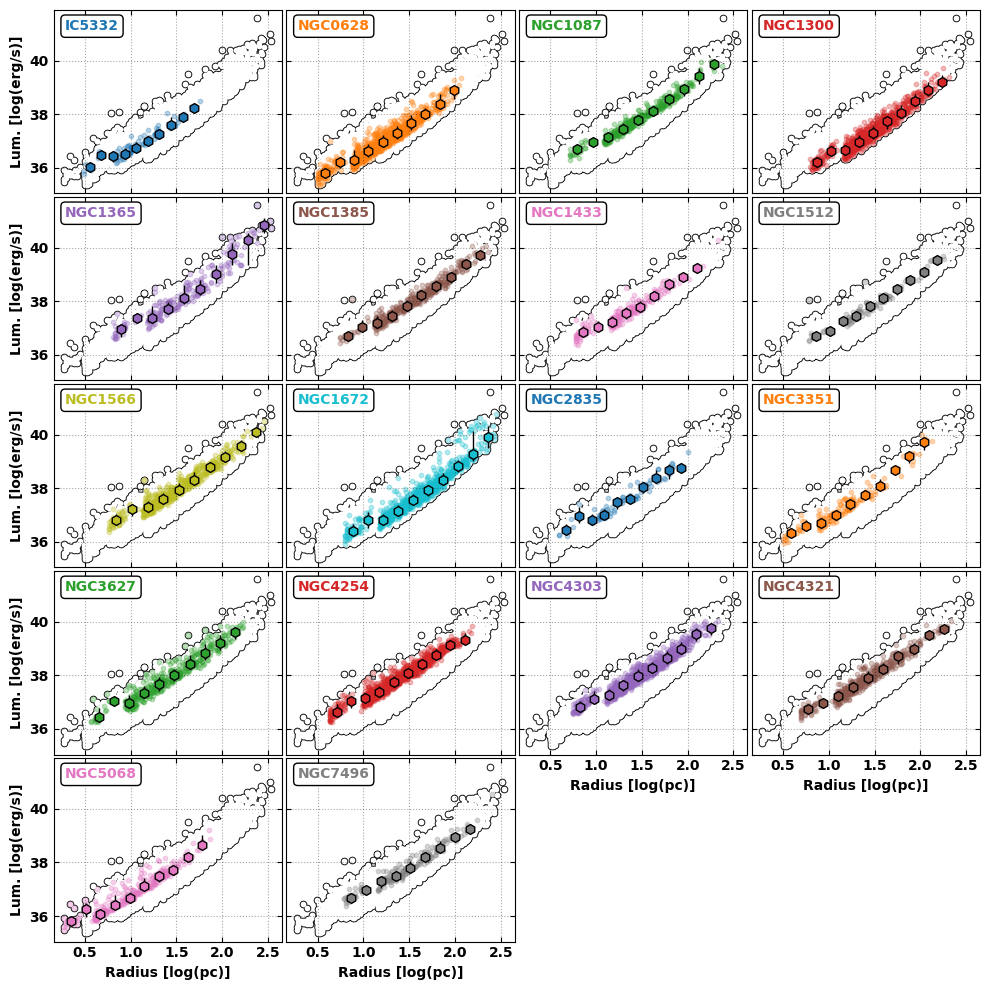

In [9]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep.pdf', dpi=150, bbox_inches='tight')

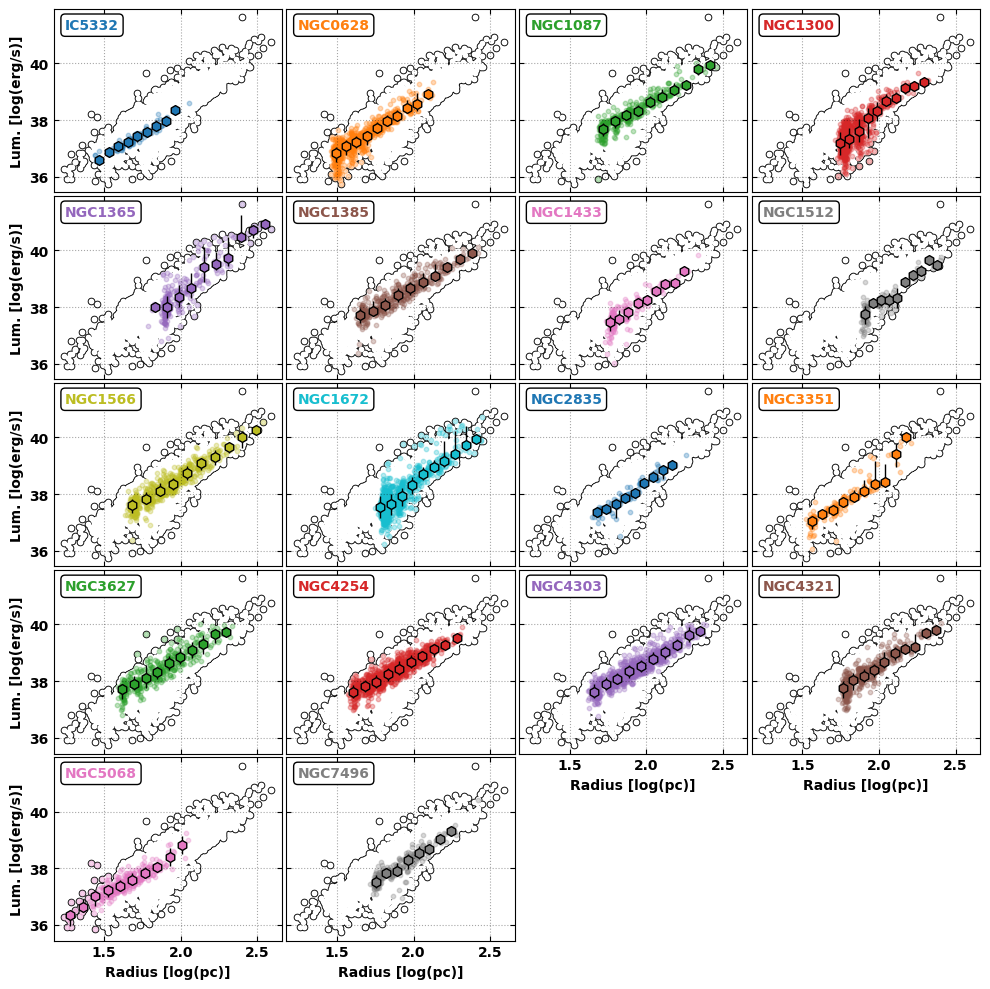

In [10]:
data_x = np.log10(table['region_circ_rad_pc_MUSE'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep_muse.pdf', dpi=150, bbox_inches='tight')

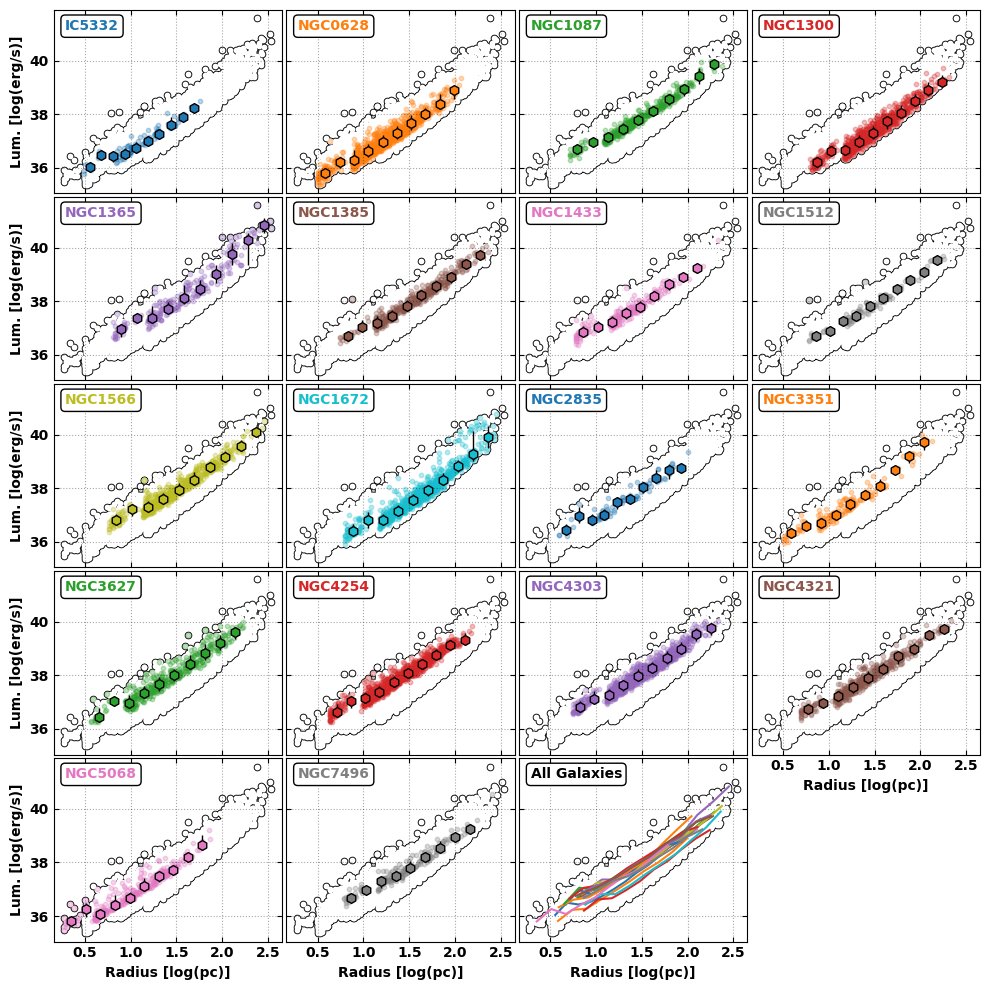

In [11]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, gal_name in enumerate(gal_names):

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Galaxies', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep.pdf', dpi=150, bbox_inches='tight')

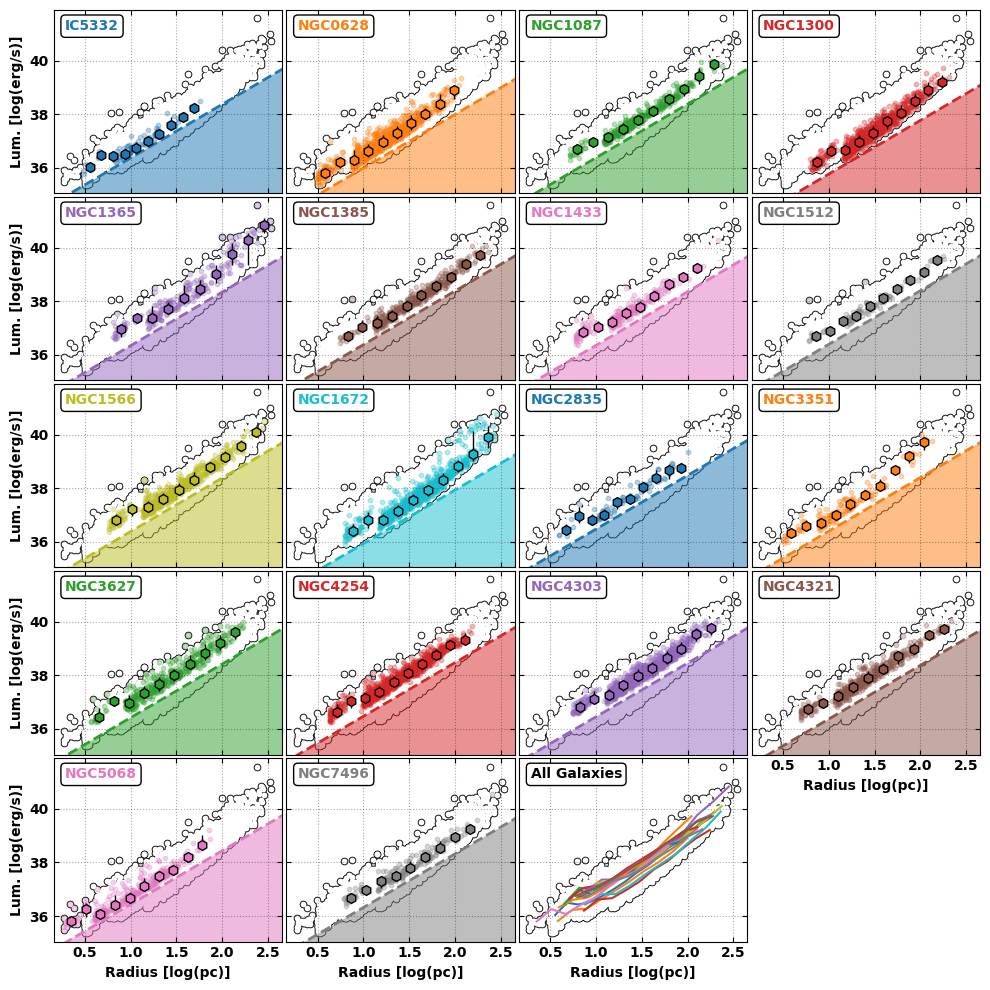

In [12]:
# Get Flux and noise stats
table_noisestats = QTable.read('./tabs/galmap_props.fits')
table_noisestats

sigma = 2
std = (table_noisestats['std'] * 1e-20 * u.erg / (u.cm ** 2) / u.s) 
std = std * sigma
pix = 0.04 * u.arcsec / 2
pix_pc = np.ones(len(std)) * u.pc
std_lum = np.ones(len(std)) * u.erg / u.s

# Get radius in pc
for i, gal_name in enumerate(np.unique(table['gal_name'])):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    pix_pc[i] = cat_props.calculate_radius(pix, dist)  
    std_lum[i] = cat_props.calculate_luminosity(std[i], dist)

data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std_lum[i].value), np.log10(std_lum.value[i]*1e6)], 'C%i'%i, ls='--', lw=2)
    
    ax.fill_between([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std_lum[i].value), np.log10(std_lum.value[i]*1e6)], fc='C%i'%i, ec='none', alpha=0.5)

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, gal_name in enumerate(gal_names):

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Galaxies', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep_sdlimit.pdf', dpi=150, bbox_inches='tight')

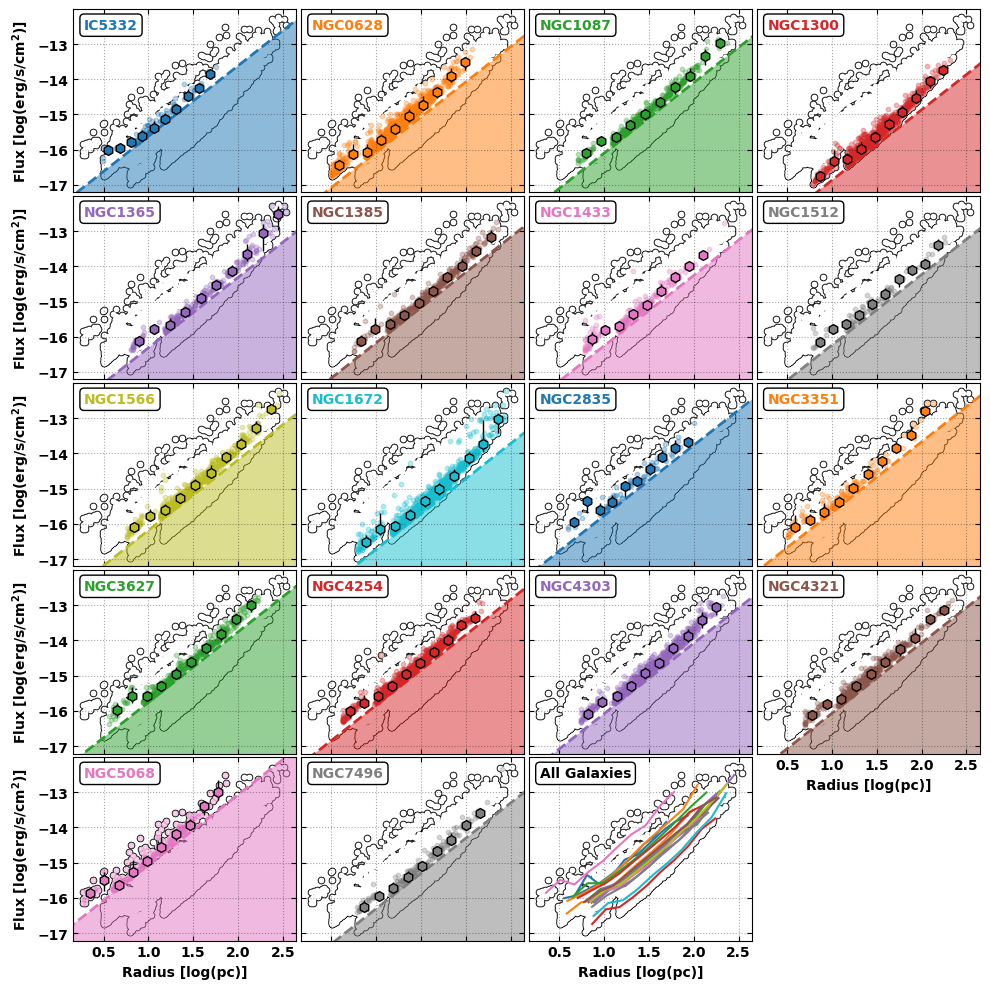

In [13]:
# Get Flux and noise stats
table_noisestats = QTable.read('./tabs/galmap_props.fits')
table_noisestats

sigma = 2
std = (table_noisestats['std'] * 1e-20 * u.erg / (u.cm ** 2) / u.s) 
std = std * sigma
pix = 0.04 * u.arcsec / 2
pix_pc = np.ones(len(std)) * u.pc

# Get radius in pc
for i, gal_name in enumerate(np.unique(table['gal_name'])):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    pix_pc[i] = cat_props.calculate_radius(pix, dist)  

### Plot 
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_FLUX_HST'].value *1e-20)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Flux [log(erg/s/cm$^2$)]')
    else:
        ax.set_yticklabels([])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std[i].value), np.log10(std.value[i]*1e6)], 'C%i'%i, ls='--', lw=2)
    
    ax.fill_between([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std[i].value), np.log10(std.value[i]*1e6)], y2=-100, fc='C%i'%i, ec='none', alpha=0.5)

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, gal_name in enumerate(gal_names):

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Galaxies', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radflux_sep_sdlimit.pdf', dpi=150, bbox_inches='tight')

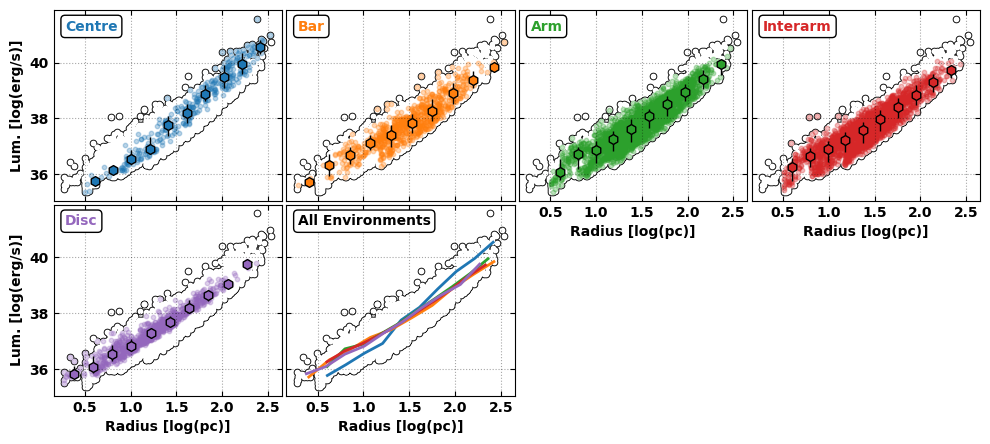

In [14]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

# environments = np.unique(table['Environment'])
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1

    data_x_, data_y_ = data_x[mask_env], data_y[mask_env]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [1,2,3,4]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, environment in enumerate(environments):

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_x_, data_y_ = data_x[mask_env], data_y[mask_env]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i, lw=2)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Environments', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_env.pdf', dpi=150, bbox_inches='tight')

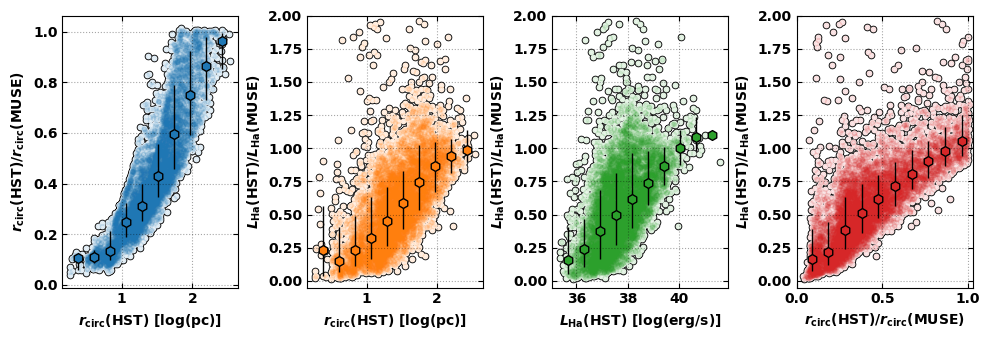

In [15]:
data_x1 = table['radius_circ_pc'].value
data_y1 = table['HA6562_LUMINOSITY_HST'].value
data_x1_log = np.log10(data_x1.copy())
data_y1_log = np.log10(data_y1.copy())

data_x2 = table['region_circ_rad_pc_MUSE'].value
data_y2 = table['HA6562_LUMINOSITY_MUSE'].value

data_x = data_x1/data_x2
data_y = data_y1/data_y2

fig = plt.figure(figsize=(10, 3.5)) 
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0', rasterized=True)

ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1', rasterized=True)

ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2', rasterized=True)

ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3', rasterized=True)

x, y, stats, bins = get_bins_1d(data_x1_log, data_x)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1_log, data_y)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_y1_log, data_y)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

ax1.grid(True, alpha=0.35, ls=':', color='black')
ax2.grid(True, alpha=0.35, ls=':', color='black')
ax3.grid(True, alpha=0.35, ls=':', color='black')
ax4.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})$ [log(pc)]')
ax2.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})$ [log(pc)]')
ax1.set_ylabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')
ax3.set_xlabel('$L_\mathrm{Ha}(\mathrm{HST})$ [log(erg/s)]')
ax4.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')
ax2.set_ylabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')
ax3.set_ylabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')
ax4.set_ylabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')

# ax3.set_yticklabels([])
# ax4.set_yticklabels([])

ax2.set_ylim(-0.05, 2)
ax3.set_ylim(-0.05, 2)
ax4.set_ylim(-0.05, 2)
ax4.set_xlim(0, 1.03)

fig.tight_layout(h_pad=0.5, w_pad=0.5)
# fig.subplots_adjust(wspace=0.2, hspace=0.02)

plt.savefig('./figs/scatter_radlumratios_all.pdf', dpi=200, bbox_inches='tight')

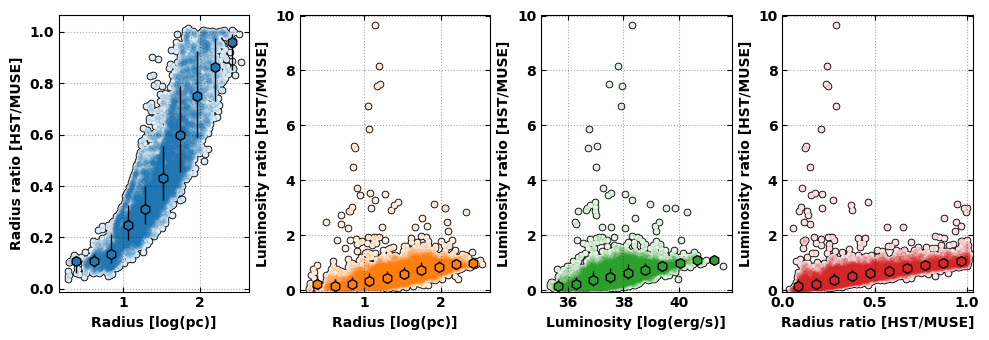

In [16]:
data_x1 = table['radius_circ_pc'].value
data_y1 = table['HA6562_LUMINOSITY_HST'].value
data_x1_log = np.log10(data_x1.copy())
data_y1_log = np.log10(data_y1.copy())

data_x2 = table['region_circ_rad_pc_MUSE'].value
data_y2 = table['HA6562_LUMINOSITY_MUSE'].value

data_x = data_x1/data_x2
data_y = data_y1/data_y2

fig = plt.figure(figsize=(10, 3.5)) 
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0', rasterized=True)

ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1', rasterized=True)

ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2', rasterized=True)

ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3', rasterized=True)

x, y, stats, bins = get_bins_1d(data_x1_log, data_x)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1_log, data_y)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_y1_log, data_y)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

ax1.grid(True, alpha=0.35, ls=':', color='black')
ax2.grid(True, alpha=0.35, ls=':', color='black')
ax3.grid(True, alpha=0.35, ls=':', color='black')
ax4.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel('Radius [log(pc)]')
ax2.set_xlabel('Radius [log(pc)]')
ax1.set_ylabel('Radius ratio [HST/MUSE]')
ax3.set_xlabel('Luminosity [log(erg/s)]')
ax4.set_xlabel('Radius ratio [HST/MUSE]')
ax2.set_ylabel('Luminosity ratio [HST/MUSE]')
ax3.set_ylabel('Luminosity ratio [HST/MUSE]')
ax4.set_ylabel('Luminosity ratio [HST/MUSE]')

# ax3.set_yticklabels([])
# ax4.set_yticklabels([])

ax2.set_ylim(-0.05, 10)
ax3.set_ylim(-0.05, 10)
ax4.set_ylim(-0.05, 10)
ax4.set_xlim(0, 1.03)

fig.tight_layout(h_pad=0.5, w_pad=0.5)
# fig.subplots_adjust(wspace=0.2, hspace=0.02)

plt.savefig('./figs/scatter_radlumratios_all_larger.pdf', dpi=200, bbox_inches='tight')

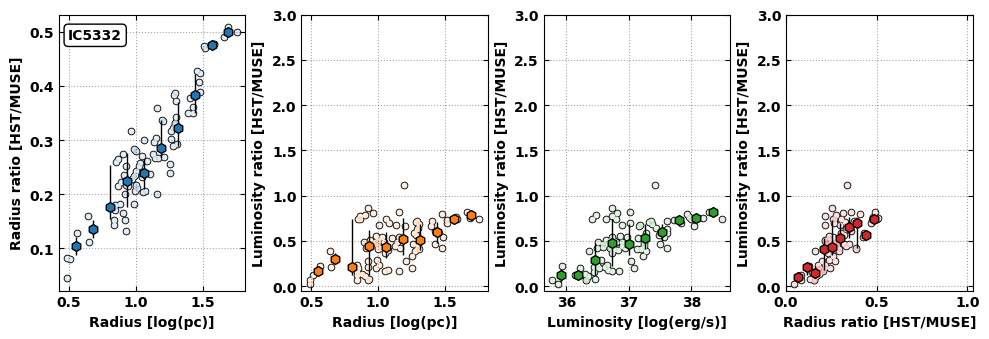

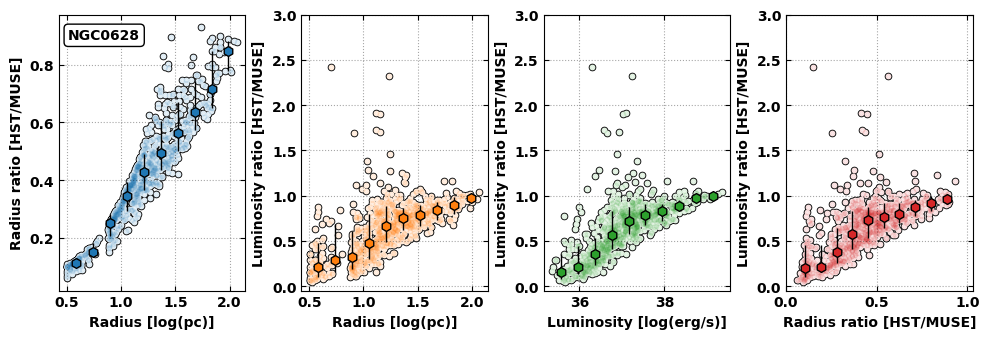

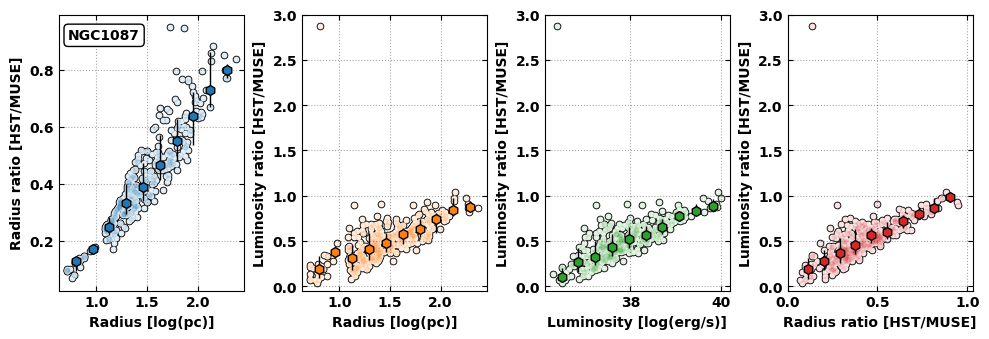

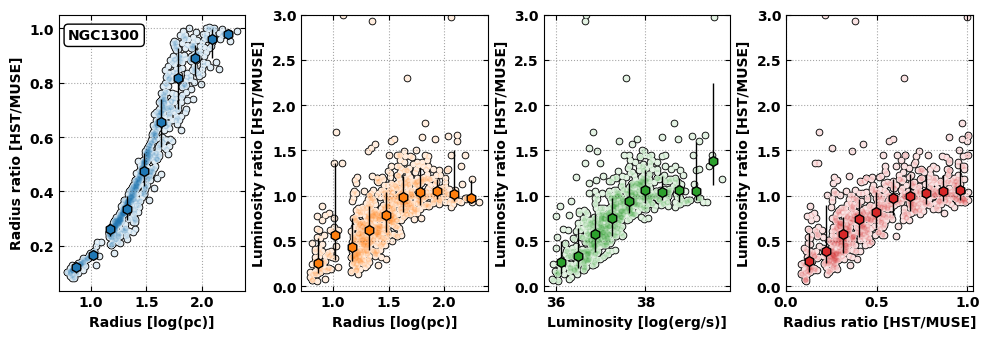

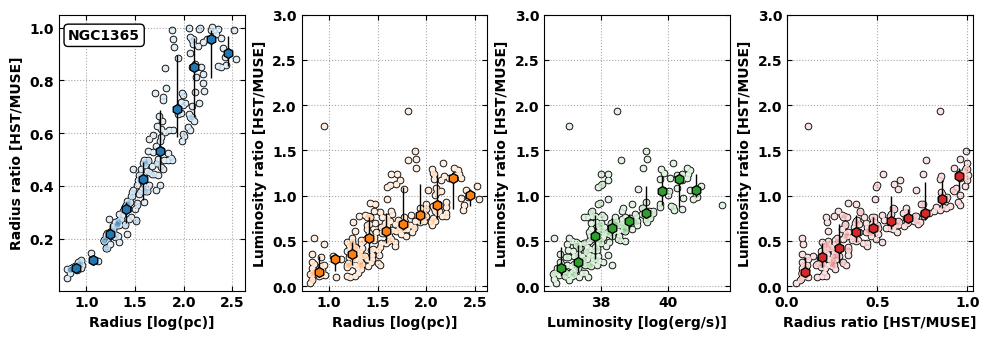

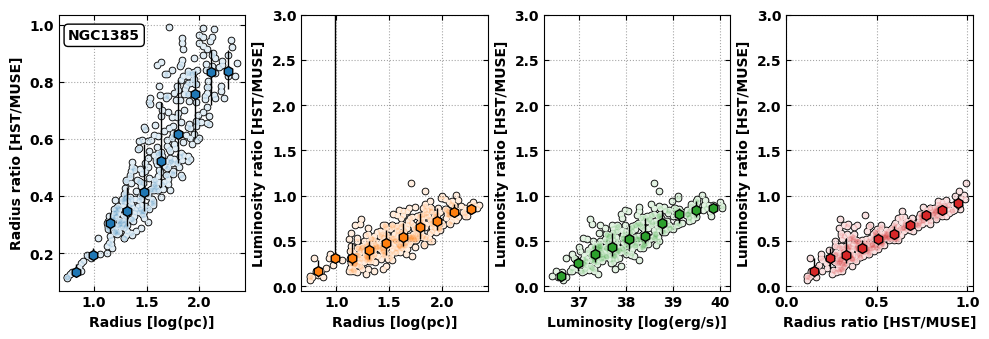

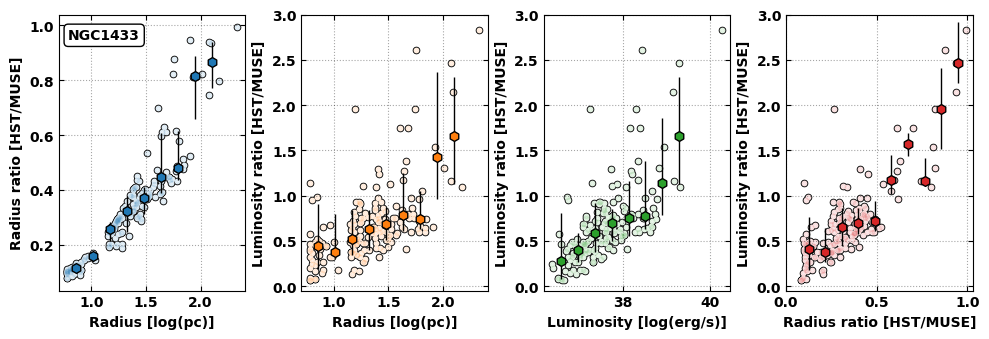

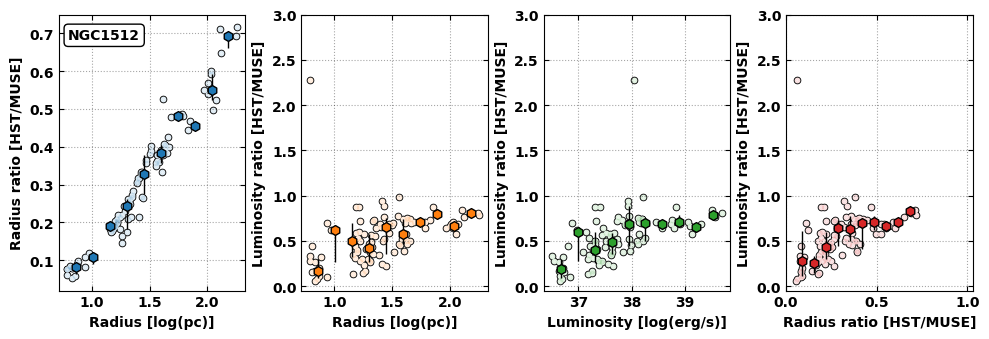

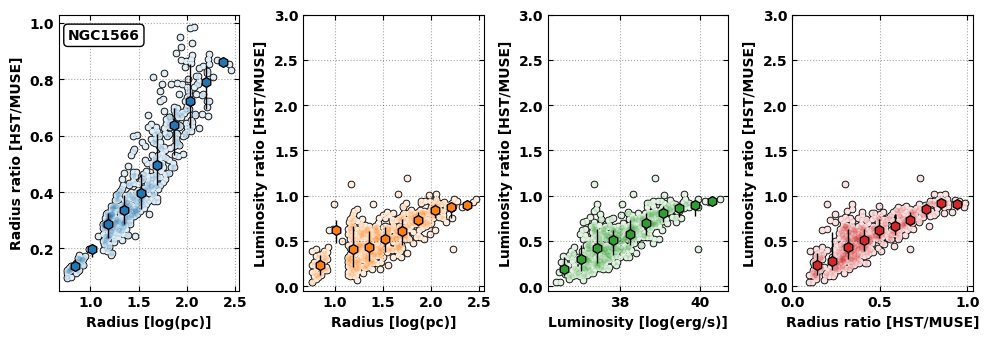

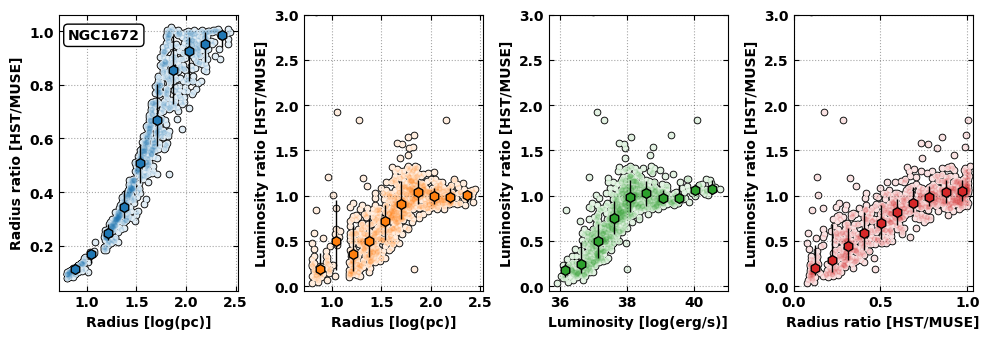

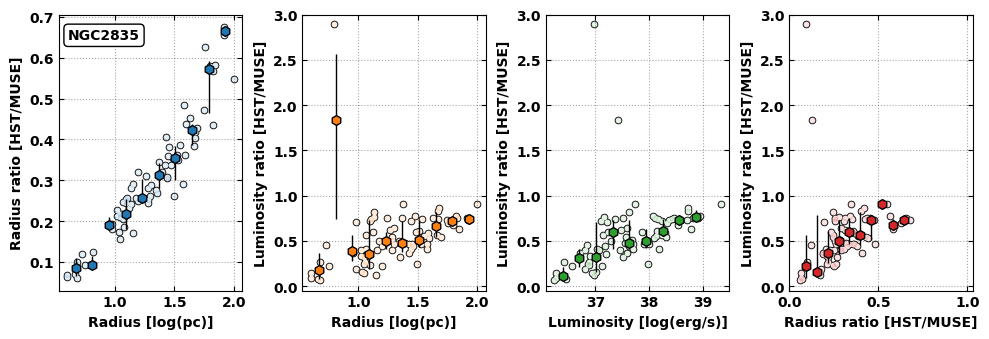

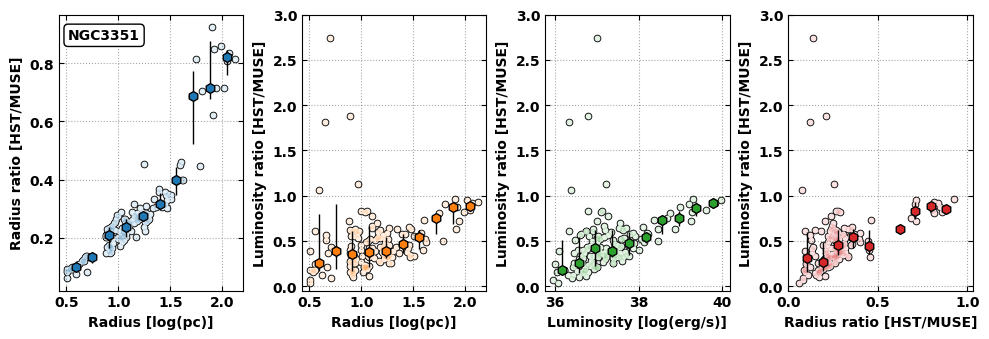

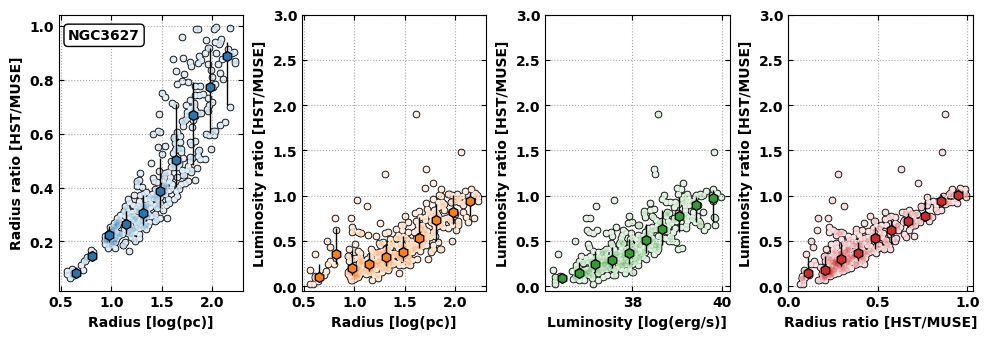

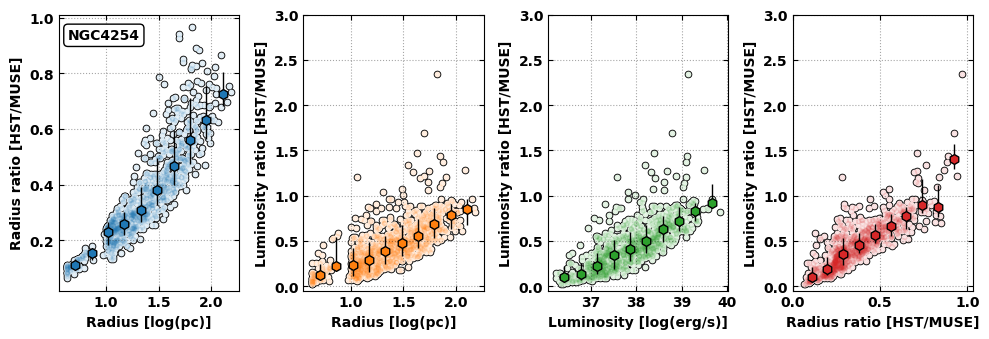

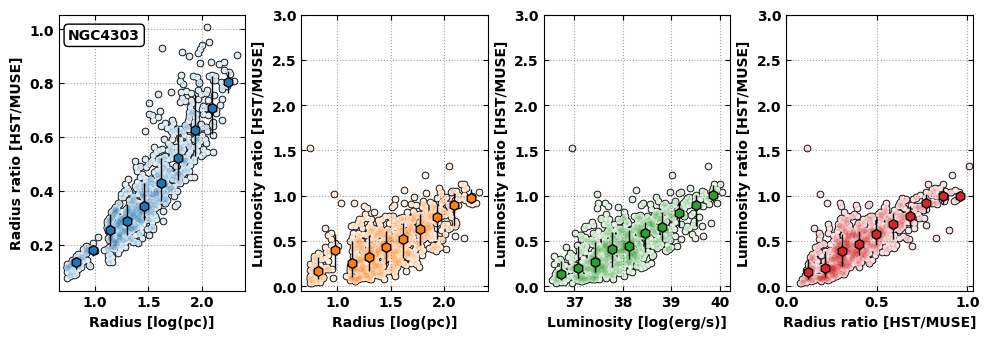

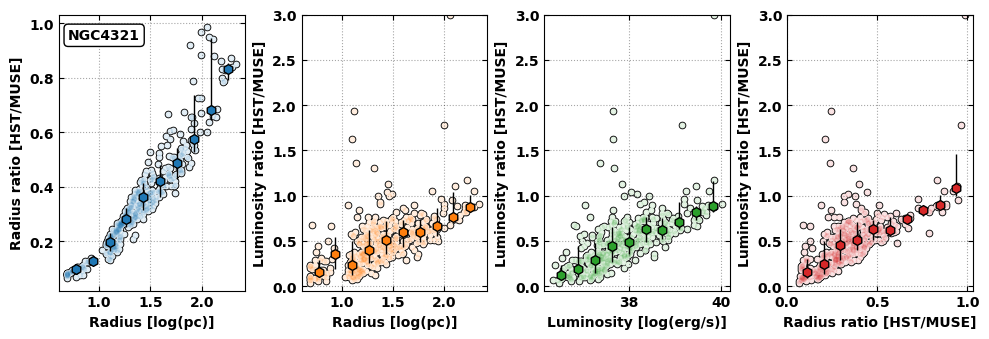

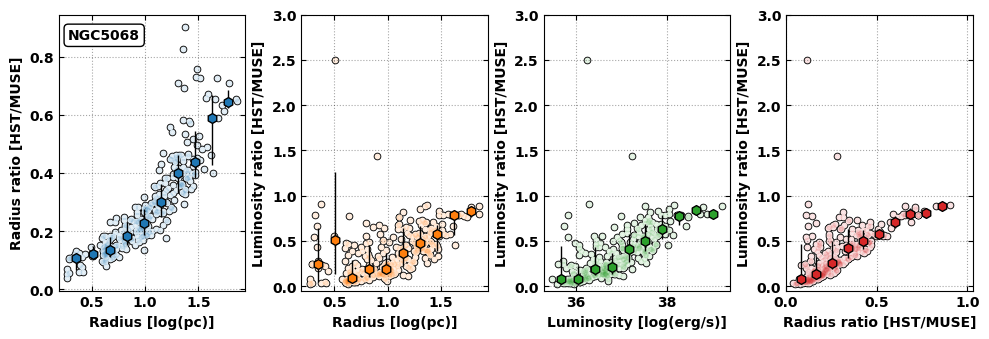

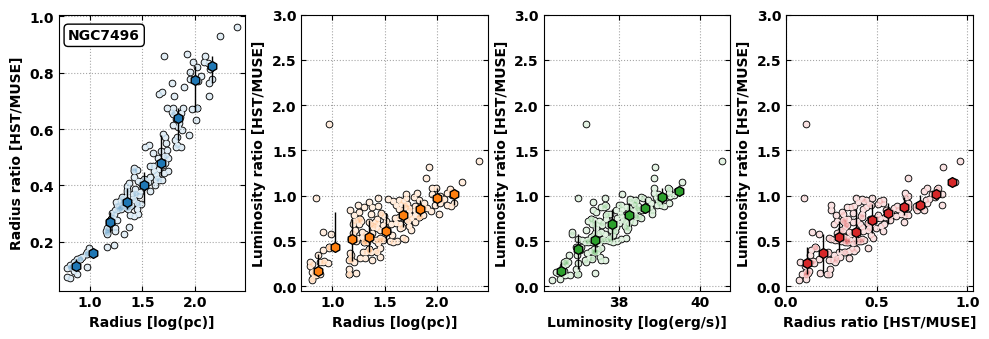

In [17]:
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):
    mask = table['gal_name'] == gal_name

    data_x1 = table['radius_circ_pc'].value[mask]
    data_y1 = table['HA6562_LUMINOSITY_HST'].value[mask]
    data_x1_log = np.log10(data_x1.copy())
    data_y1_log = np.log10(data_y1.copy())

    data_x2 = table['region_circ_rad_pc_MUSE'].value[mask]
    data_y2 = table['HA6562_LUMINOSITY_MUSE'].value[mask]

    data_x = data_x1/data_x2
    data_y = data_y1/data_y2

    fig = plt.figure(figsize=(10, 3.5)) 
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
    ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
    ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0')

    ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
    ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
    ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1')

    ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
    ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
    ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2')

    ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3')

    x, y, stats, bins = get_bins_1d(data_x1_log, data_x)
    ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

    x, y, stats, bins = get_bins_1d(data_x1_log, data_y)
    ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

    x, y, stats, bins = get_bins_1d(data_y1_log, data_y)
    ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

    ax1.grid(True, alpha=0.35, ls=':', color='black')
    ax2.grid(True, alpha=0.35, ls=':', color='black')
    ax3.grid(True, alpha=0.35, ls=':', color='black')
    ax4.grid(True, alpha=0.35, ls=':', color='black')

    ax1.set_xlabel('Radius [log(pc)]')
    ax2.set_xlabel('Radius [log(pc)]')
    ax1.set_ylabel('Radius ratio [HST/MUSE]')
    ax3.set_xlabel('Luminosity [log(erg/s)]')
    ax4.set_xlabel('Radius ratio [HST/MUSE]')
    ax2.set_ylabel('Luminosity ratio [HST/MUSE]')
    ax3.set_ylabel('Luminosity ratio [HST/MUSE]')
    ax4.set_ylabel('Luminosity ratio [HST/MUSE]')

    ax1.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='k')

    ax2.set_ylim(-0.05, 3)
    ax3.set_ylim(-0.05, 3)
    ax4.set_ylim(-0.05, 3)
    ax4.set_xlim(0, 1.03)

    fig.tight_layout(h_pad=0.5, w_pad=0.5)
    # fig.subplots_adjust(wspace=0.2, hspace=0.02)

    plt.savefig('./figs/scatter_radlumratios_%s.pdf' %gal_name, dpi=200, bbox_inches='tight')